In [1]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import disk
from skimage.io import imsave
import time


sys.path.append('../src')
import unet7

In [2]:
#code to check for GPU
import tensorflow as tf

print("Num CPUs Available: ", len(tf.compat.v1.config.list_physical_devices('CPU')))
print("Num GPUs Available: ", len(tf.compat.v1.config.list_physical_devices('GPU')))

Num CPUs Available:  1
Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8184225771535807216
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16149970944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1237700528517702530
physical_device_desc: "device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 6.0"
xla_global_id: 416903419
]


2022-05-18 18:31:32.002235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-18 18:31:35.222800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 6.0


In [4]:
import keras
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} ) 
sess = tf.compat.v1.Session(config=config) 
keras.backend.set_session(sess)

2022-05-18 18:33:01.019941: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 6.0


In [5]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
epochs = 10 #100 1001
batch_size = 80
smooth = 1.
start_lr = 1e-4
target_width = 256
target_height = 256

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_rows / target_height

In [6]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs

def test_model(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred))

    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true))

    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.pdf'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()

In [7]:
runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = os.path.join('..','data')
log_dir = os.path.join(model_dir, 'Practice','logs',"{}".format(runningTime))
checkDir(log_dir)

In [8]:
# Training


tensorboard = TensorBoard(log_dir=os.path.join(model_dir,"{}".format(runningTime)))
#tensorboard = TensorBoard(log_dir=log_dir)

callbacksList = [tensorboard]

#model = unet7.get_unet(img_cols, img_rows)
model = unet7.Unet(target_width, target_width, nclasses=1)

#model.compile(optimizer=Adam(lr=5e-5), loss=unet7.dice_coef_loss, metrics=[unet7.dice_coef])
model.compile(optimizer=Adam(learning_rate=start_lr), loss=unet7.dice_loss, metrics=[unet7.dice_coeff])

model.summary()
#print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(model_dir,"{}".format(runningTime)+"\""))
print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir+"\""))

2022-05-18 18:33:20.209791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-SXM2-16GB, pci bus id: 0000:62:00.0, compute capability: 6.0


Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

 spatial_dropout2d_3 (SpatialDr  (None, 16, 16, 64)  0           ['max_pooling2d_3[0][0]']        
 opout2D)                                                                                         
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 128)  73856       ['spatial_dropout2d_3[0][0]']    
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 128)  512        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 

                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 16  64         ['conv2d_15[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_15 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 spatial_dropout2d_7 (SpatialDr  (None, 128, 128, 16  0          ['activation_15[0][0]']          
 opout2D)                       )                                                                 
                                                                                                  
 conv2d_tr

In [9]:
data = np.load('../data/full_res_patch_dataset_sample.npz')
training_imgs=data['training_imgs']
training_masks=data['training_masks']
test_imgs=data['test_imgs']
test_masks=data['test_masks']
del data

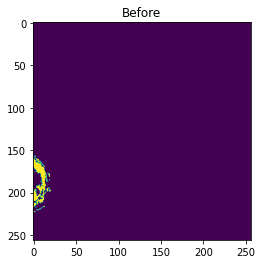

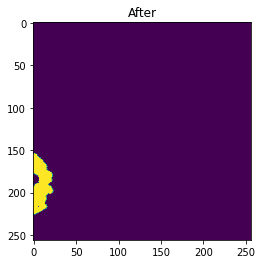

In [10]:
# improve the masks
test = training_masks[0]
plt.figure()
plt.title('Before')
plt.imshow(np.squeeze(test))

footprint = disk(3)
test = dilation(np.squeeze(test), footprint)


plt.figure()
plt.title('After')
plt.imshow(np.squeeze(test))

In [11]:
for i in range(training_masks.shape[0]):
    training_masks[i,:,:,0] = dilation(np.squeeze(training_masks[i,:,:,0]), footprint)

for i in range(test_masks.shape[0]):
    test_masks[i,:,:,0] = dilation(np.squeeze(test_masks[i,:,:,0]), footprint)

In [12]:
# Data augmentation

img_gen_args = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**img_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

seed = 123
image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)

gen_train = zip(image_generator, mask_generator)


img_gen_args_test = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args_test = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen_test = ImageDataGenerator(**img_gen_args_test)
mask_datagen_test = ImageDataGenerator(**mask_gen_args_test)

seed = 123
image_datagen_test.fit(test_imgs, augment=True, seed=seed)
mask_datagen_test.fit(test_masks, augment=True, seed=seed)

image_generator_test = image_datagen_test.flow(test_imgs, batch_size=batch_size, seed=seed)
mask_generator_test = mask_datagen_test.flow(test_masks, batch_size=batch_size, seed=seed)

gen_test = zip(image_generator_test, mask_generator_test)

In [13]:
history = model.fit(
        gen_train,
        batch_size = batch_size,
        steps_per_epoch=training_imgs.shape[0] // epochs, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)



Epoch 1/10


2022-05-18 18:33:49.444089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201


1/1 [==============================] - 7s 7s/step - loss: 0.9498 - dice_coeff: 0.0502 - val_loss: 0.9121 - val_dice_coeff: 0.0879
Epoch 2/10
1/1 [==============================] - 0s 124ms/step - loss: 0.9520 - dice_coeff: 0.0480 - val_loss: 0.9113 - val_dice_coeff: 0.0887
Epoch 3/10
1/1 [==============================] - 0s 88ms/step - loss: 0.9460 - dice_coeff: 0.0540 - val_loss: 0.9106 - val_dice_coeff: 0.0894
Epoch 4/10
1/1 [==============================] - 0s 83ms/step - loss: 0.9511 - dice_coeff: 0.0489 - val_loss: 0.9099 - val_dice_coeff: 0.0901
Epoch 5/10
1/1 [==============================] - 0s 90ms/step - loss: 0.9500 - dice_coeff: 0.0500 - val_loss: 0.9092 - val_dice_coeff: 0.0908
Epoch 6/10
1/1 [==============================] - 0s 83ms/step - loss: 0.9480 - dice_coeff: 0.0520 - val_loss: 0.9085 - val_dice_coeff: 0.0915
Epoch 7/10
1/1 [==============================] - 0s 83ms/step - loss: 0.9488 - dice_coeff: 0.0512 - val_loss: 0.9079 - val_dice_coeff: 0.0921
Epoch 8/10


In [14]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'dice_coeff', 'val_loss', 'val_dice_coeff'])


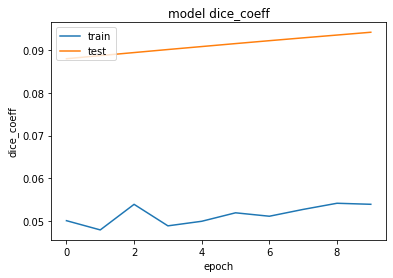

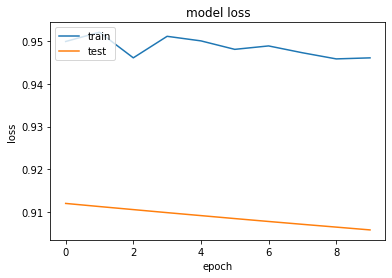

In [15]:
# summarize history for accuracy
plt.plot(history.history['dice_coeff'])
plt.plot(history.history['val_dice_coeff'])
plt.title('model dice_coeff')
plt.ylabel('dice_coeff')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

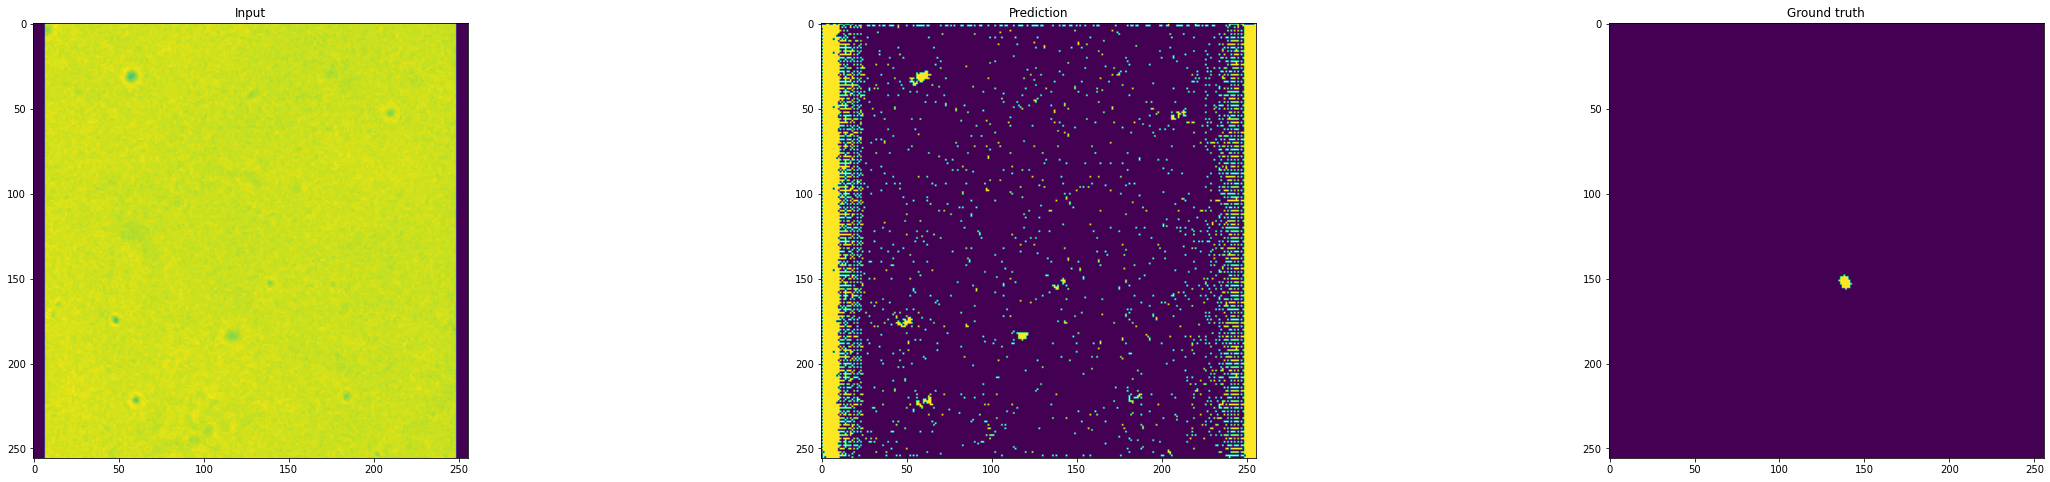

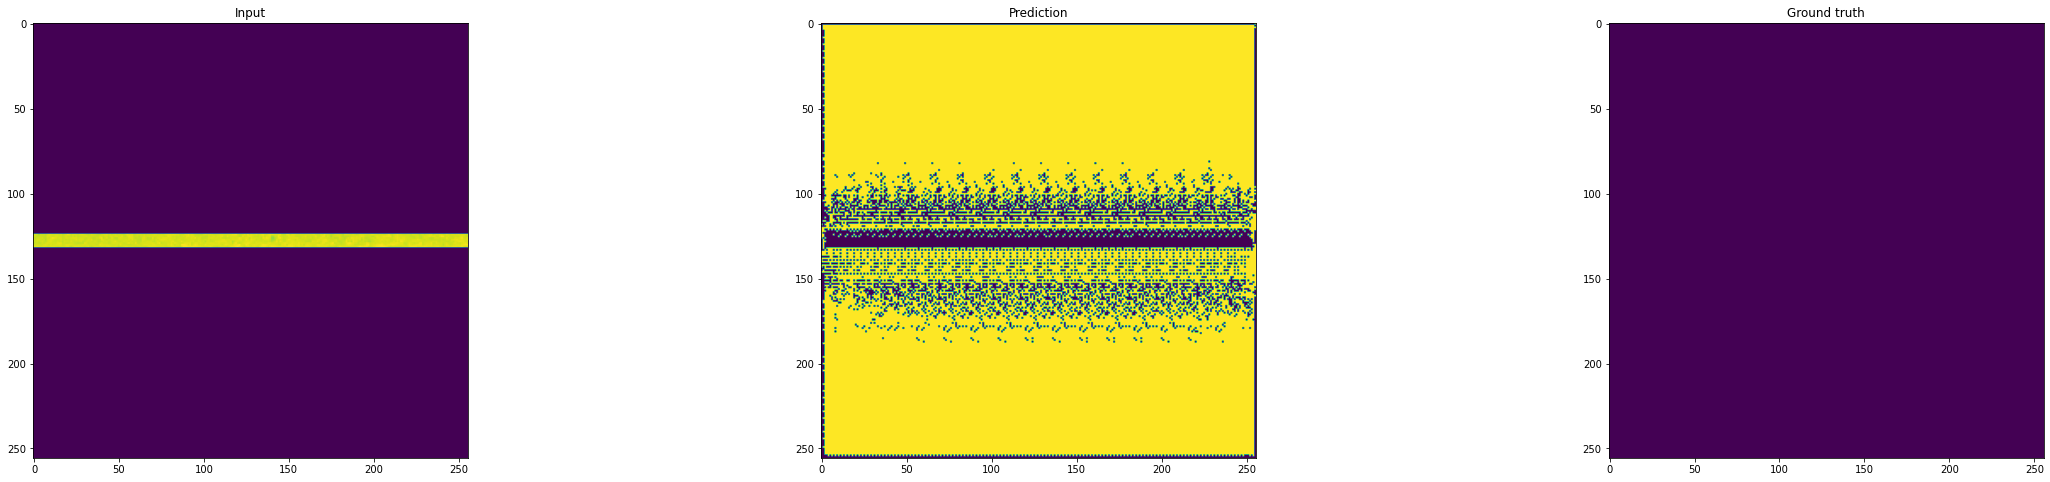

In [16]:
img_exmp = image_generator.next()
mask_exmp = mask_generator.next()
test_model(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = image_generator_test.next()
test_mask_exmp = mask_generator_test.next()
test_model(model, test_img_exmp, test_mask_exmp, log_dir)

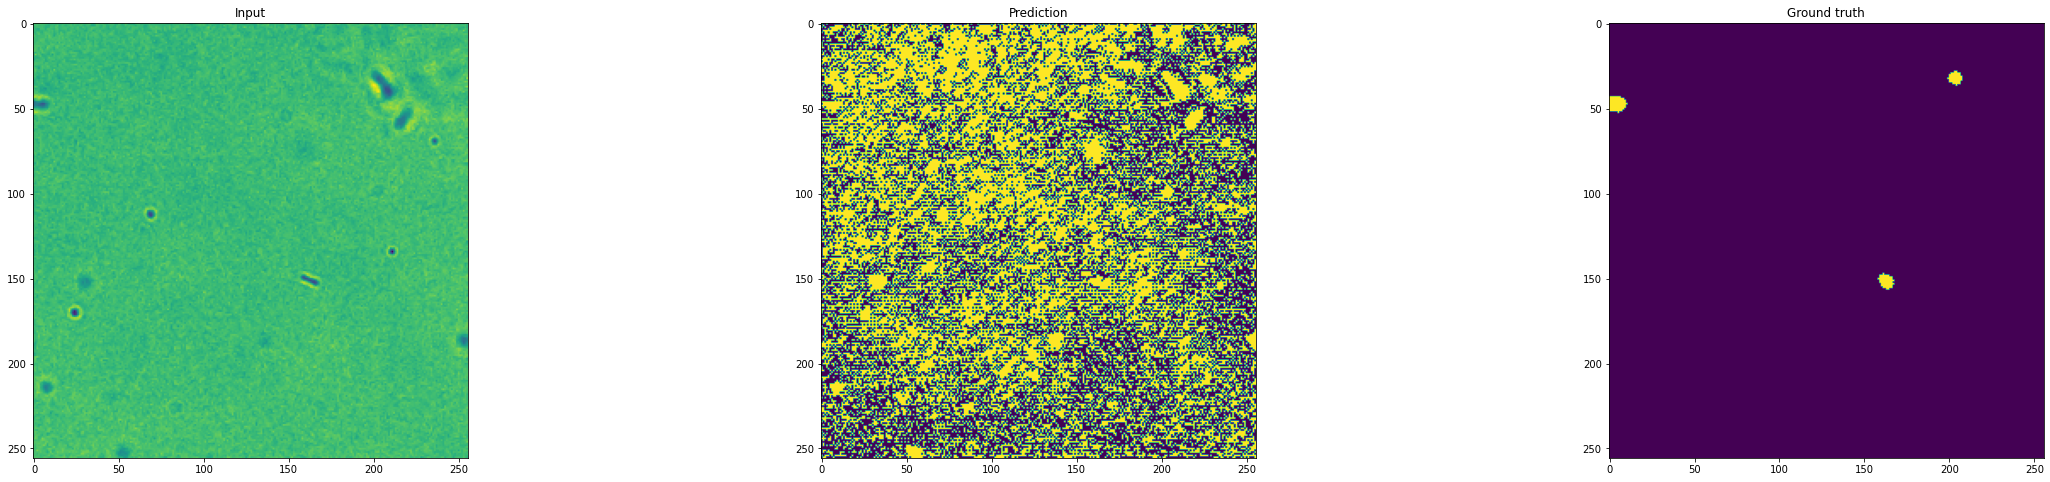

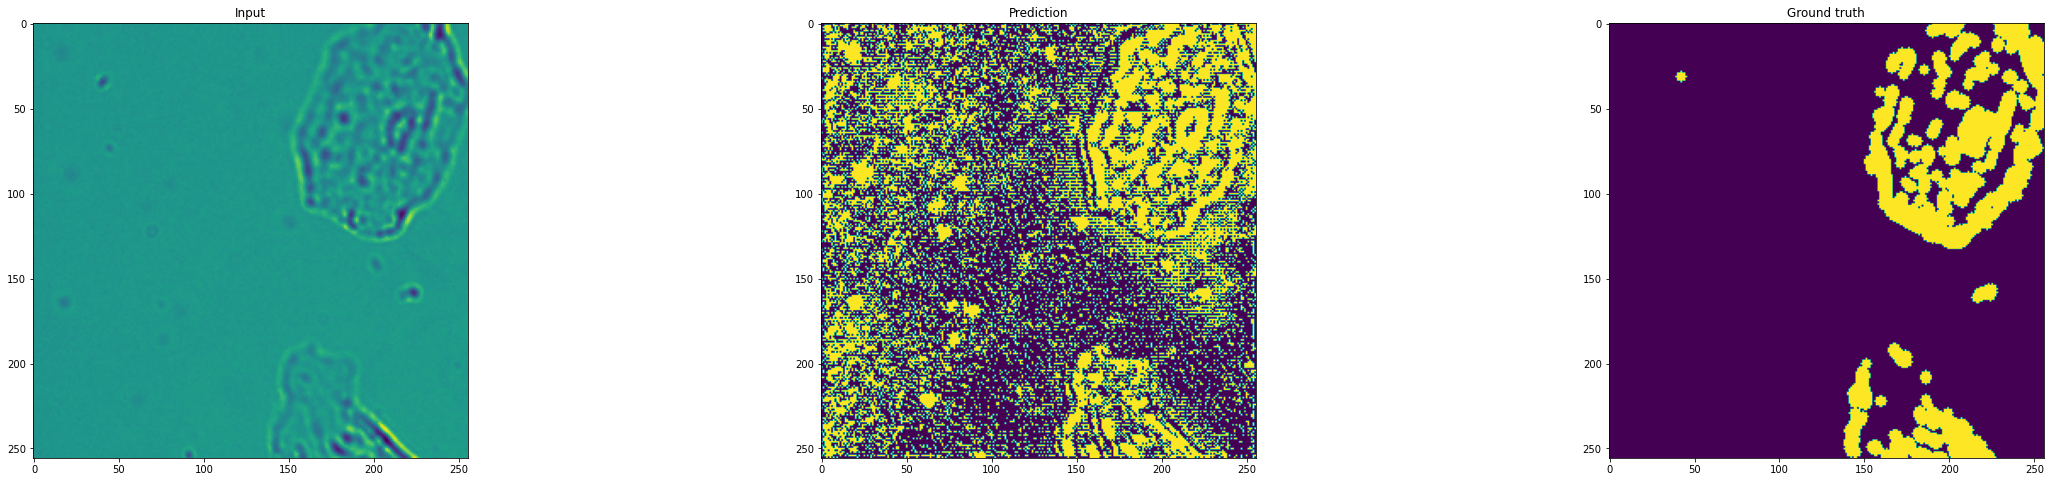

In [17]:
img_exmp = image_generator.next()
mask_exmp = mask_generator.next()
test_model(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = image_generator_test.next()
test_mask_exmp = mask_generator_test.next()
test_model(model, test_img_exmp, test_mask_exmp, log_dir)

In [18]:
#Saving the model and rerunning
model.save(os.path.join(log_dir,runningTime+'.h5'))

In [19]:
from tensorflow import keras

reloaded_model = keras.models.load_model(os.path.join(log_dir,runningTime+'.h5'),custom_objects = {"dice_loss": unet7.dice_loss, "dice_coeff": unet7.dice_coeff})
reloaded_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

 spatial_dropout2d_3 (SpatialDr  (None, 16, 16, 64)  0           ['max_pooling2d_3[0][0]']        
 opout2D)                                                                                         
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 128)  73856       ['spatial_dropout2d_3[0][0]']    
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 16, 16, 128)  512        ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 16, 16, 128)  0           ['batch_normalization_8[0][0]']  
                                                                                                  
 conv2d_9 

                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 16  64         ['conv2d_15[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_15 (Activation)     (None, 128, 128, 16  0           ['batch_normalization_15[0][0]'] 
                                )                                                                 
                                                                                                  
 spatial_dropout2d_7 (SpatialDr  (None, 128, 128, 16  0          ['activation_15[0][0]']          
 opout2D)                       )                                                                 
                                                                                                  
 conv2d_tr

In [20]:
!nvidia-smi

Wed May 18 18:34:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-SXM2...  On   | 00000000:62:00.0 Off |                  Off |
| N/A   41C    P0    42W / 300W |  16029MiB / 16384MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------